In [3]:
from modules.uploadData import *
from modules.getData import *
from modules.data_setup import create_dataloaders

In [20]:
# zip_data("goose_ducks_dataset")

In [21]:
# get_data_from_github("goose_ducks_dataset")

In [1]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Skalowanie obrazów do 64x64
    transforms.ToTensor(),  # Konwersja obrazu do tensora PyTorch
    transforms.RandomHorizontalFlip(),  # Add horizontal flip
    transforms.RandomRotation(10),  # Add random rotation
])

In [4]:
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir = "data/goose_ducks_dataset/test",
    test_dir = "data/goose_ducks_dataset/train",
    batch_size=32,
    transform=transform
)

In [5]:
import torch
from modules import model_builder

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)
model = model_builder.TinyVGG(input_shape=3,
                              hidden_units=10, 
                              output_shape=len(class_names)).to(device)

In [6]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

In [15]:
from modules.engine import train

train(
    model=model, 
    train_dataloader=train_dataloader, 
    test_dataloader=test_dataloader, 
    optimizer=optimizer,
    loss_fn=loss_fn, 
    epochs=10,
    device=device)

 10%|█         | 1/10 [00:09<01:23,  9.31s/it]

Epoch: 1  | Train Loss: 0.6918  | Train Accuracy: 0.4500  | Test Loss: 0.6792  | Test Accuracy: 0.7708


 20%|██        | 2/10 [00:18<01:13,  9.16s/it]

Epoch: 2  | Train Loss: 0.6881  | Train Accuracy: 0.5500  | Test Loss: 0.6608  | Test Accuracy: 0.7708


 30%|███       | 3/10 [00:27<01:03,  9.07s/it]

Epoch: 3  | Train Loss: 0.6846  | Train Accuracy: 0.5500  | Test Loss: 0.6412  | Test Accuracy: 0.7708


 40%|████      | 4/10 [00:36<00:54,  9.05s/it]

Epoch: 4  | Train Loss: 0.6823  | Train Accuracy: 0.5500  | Test Loss: 0.6223  | Test Accuracy: 0.7708


 50%|█████     | 5/10 [00:45<00:45,  9.02s/it]

Epoch: 5  | Train Loss: 0.6811  | Train Accuracy: 0.5500  | Test Loss: 0.6068  | Test Accuracy: 0.7708


 60%|██████    | 6/10 [00:54<00:36,  9.07s/it]

Epoch: 6  | Train Loss: 0.6808  | Train Accuracy: 0.5500  | Test Loss: 0.5977  | Test Accuracy: 0.7708


 70%|███████   | 7/10 [01:03<00:27,  9.04s/it]

Epoch: 7  | Train Loss: 0.6806  | Train Accuracy: 0.5500  | Test Loss: 0.5953  | Test Accuracy: 0.7708


 80%|████████  | 8/10 [01:12<00:18,  9.04s/it]

Epoch: 8  | Train Loss: 0.6795  | Train Accuracy: 0.5500  | Test Loss: 0.5983  | Test Accuracy: 0.7708


 90%|█████████ | 9/10 [01:21<00:09,  9.02s/it]

Epoch: 9  | Train Loss: 0.6767  | Train Accuracy: 0.5500  | Test Loss: 0.6046  | Test Accuracy: 0.7708


100%|██████████| 10/10 [01:30<00:00,  9.05s/it]

Epoch: 10  | Train Loss: 0.6736  | Train Accuracy: 0.5500  | Test Loss: 0.6125  | Test Accuracy: 0.7708


{'train_loss': [0.6918157339096069,
  0.6881283521652222,
  0.6845664381980896,
  0.6823102235794067,
  0.6810921430587769,
  0.6808117628097534,
  0.680557906627655,
  0.6795014142990112,
  0.6767256259918213,
  0.673552393913269],
 'train_accuracy': [0.45,
  0.55,
  0.55,
  0.55,
  0.55,
  0.55,
  0.55,
  0.55,
  0.55,
  0.55],
 'test_loss': [0.6791561643282572,
  0.6608231663703918,
  0.6412237286567688,
  0.6223295132319132,
  0.6067568262418112,
  0.5977322061856588,
  0.5952737132708231,
  0.5982956886291504,
  0.6045602560043335,
  0.6125095089276632],
 'test_accuracy': [0.7708333333333334,
  0.7708333333333334,
  0.7708333333333334,
  0.7708333333333334,
  0.7708333333333334,
  0.7708333333333334,
  0.7708333333333334,
  0.7708333333333334,
  0.7708333333333334,
  0.7708333333333334]}

In [ ]:
from modules.utils import save_model

save_model(
    model=model, 
    target_directory="models", 
    model_name="goose_ducks_model_Adam_10Epoch.pth",
    )

Saving model to models\goose_ducks_model_SGDoptim_10Epoch.pth


In [ ]:
import torch
from typing import Dict

def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn
) -> Dict[str, float]:
    model.eval()
    loss, accuracy = 0, 0

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y).item()
            accuracy += accuracy_fn(y_pred, y)

    loss /= len(data_loader)
    accuracy /= len(data_loader)
    return {"loss": loss, "accuracy": accuracy}

In [26]:
from modules.plots import plot_loss_curves
import torch
from modules import model_builder, utils, engine

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the saved model
model_path = "models/goose_ducks_model_01.pth"
torch.manual_seed(42)

# Create an instance of the model
model = model_builder.TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

# Load the state dictionary into the model
model.load_state_dict(torch.load(model_path))

# Evaluate the loaded model
loaded_model_results = engine.eval_model(
    model=model,
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
)

# Print the evaluation results
print(loaded_model_results)

# Assuming you have saved the training history in a file
with open("models/training_history.pkl", "rb") as f:
    history = pickle.load(f)

# Plot the loss curves
plot_loss_curves(history)

AttributeError: module 'modules.engine' has no attribute 'eval_model'

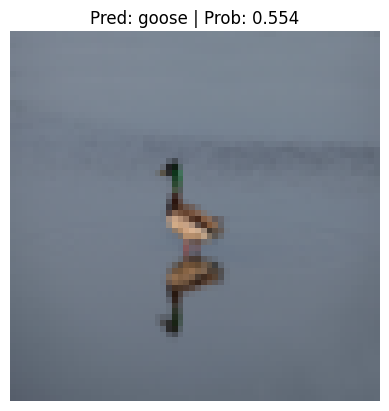

In [ ]:
from modules.plots import pred_and_plot_image
import torch
from modules import model_builder

device = "cuda" if torch.cuda.is_available() else "cpu"

model_path = "models/goose_ducks_model_SGDoptim_10Epoch.pth"
torch.manual_seed(42)

model = model_builder.TinyVGG(input_shape=3,
                              hidden_units=20, 
                              output_shape=len(class_names)).to(device)
model.load_state_dict(torch.load(model_path))

custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])
custom_image_path = "data/my_ducky.jpg"

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

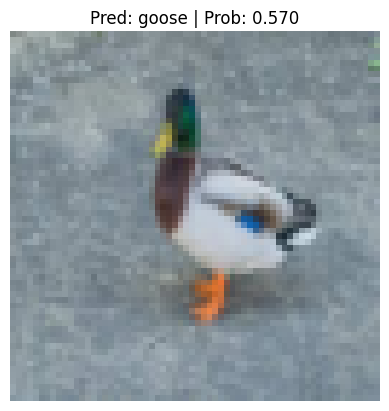

In [20]:
from modules.plots import pred_and_plot_image
import torch
from modules import model_builder

custom_image_path = "data/my_ducky2.jpg"
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
from modules.train import train_model




In [22]:
python train.py

SyntaxError: invalid syntax (3458882724.py, line 1)